In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [2]:
os.chdir('../data/interim')

In [3]:
os.listdir()

['joined data post-markdowns.csv',
 'joined data pre-markdowns.csv',
 '.gitkeep',
 'data post-eda.csv',
 'joined data full.csv']

### Generate Dummy Features

My approach is going to be dropping the markdown columns in order to have access to the entire data set for training.

In [86]:
# Loading full joined data as df
df = pd.read_csv('data post-eda.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1


In [87]:
# Dropping markdown columns
df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [88]:
# Show info of remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  int64  
 10  Size          421570 non-null  int64  
 11  Month         421570 non-null  int64  
 12  Week          421570 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 41.8+ MB


Columns that should have dummy features encoded:
- Store
- Dept
- Type
- Month
- Week

In [89]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,211.671989,7.838,2,151315,1,1


I plan to create 3 separate models. One for each of the different store types.

In [90]:
# Create dummy features
deptDummies = pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)
monthDummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
weekDummies = pd.get_dummies(df['Week'], prefix='Week', drop_first=True)

In [91]:
# Join dummy features onto dataframe
df = df.join([deptDummies, monthDummies, weekDummies])

In [92]:
# Drop original features
df.drop(columns=['Dept', 'Month', 'Week'], inplace=True)

In [93]:
# Split the data by 3 store types
df0 = df.loc[df.Type == 0]
df1 = df.loc[df.Type == 1]
df2 = df.loc[df.Type == 2]

In [94]:
# Drop Type and Date features
df0 = df0.drop(columns=['Type'])
df1 = df1.drop(columns=['Type'])
df2 = df2.drop(columns=['Type'])

In [95]:
# Create Store Dummy Features
storeDummies0 = pd.get_dummies(df0['Store'], prefix='Store', drop_first=True)
storeDummies1 = pd.get_dummies(df1['Store'], prefix='Store', drop_first=True)
storeDummies2 = pd.get_dummies(df2['Store'], prefix='Store', drop_first=True)

In [96]:
# Join Store dummes to dataframes
df0 = df0.join(storeDummies0)
df1 = df1.join(storeDummies1)
df2 = df2.join(storeDummies2)

In [97]:
# Drop Store columns from dataframes
df0 = df0.drop(columns=['Store'])
df1 = df1.drop(columns=['Store'])
df2 = df2.drop(columns=['Store'])

In [98]:
# Print dataframe shapes
print(df0.shape)
print(df1.shape)
print(df2.shape)

(42597, 155)
(163495, 166)
(215478, 171)


### Train Test Split

We want to perform a train test split prior to scaling the data to prevent data leakage

In [99]:
trainmask0 = df0.Date < '2012-01-01'
testmask0 = df0.Date >= '2012-01-01'
trainmask1 = df1.Date < '2012-01-01'
testmask1 = df1.Date >= '2012-01-01'
trainmask2 = df2.Date < '2012-01-01'
testmask2 = df2.Date >= '2012-01-01'

In [100]:
dftrain0 = df0.loc[trainmask0]
dftest0 = df0.loc[testmask0]
dftrain1 = df1.loc[trainmask1]
dftest1 = df1.loc[testmask1]
dftrain2 = df2.loc[trainmask2]
dftest2 = df2.loc[testmask2]

In [101]:
X_train0 = dftrain0.drop(columns=['Date', 'Weekly_Sales'])
y_train0 = dftrain0[['Weekly_Sales']]
X_test0 = dftest0.drop(columns=['Date', 'Weekly_Sales'])
y_test0 = dftest0[['Weekly_Sales']]
X_train1 = dftrain1.drop(columns=['Date', 'Weekly_Sales'])
y_train1 = dftrain1[['Weekly_Sales']]
X_test1 = dftest1.drop(columns=['Date', 'Weekly_Sales'])
y_test1 = dftest1[['Weekly_Sales']]
X_train2 = dftrain2.drop(columns=['Date', 'Weekly_Sales'])
y_train2 = dftrain2[['Weekly_Sales']]
X_test2 = dftest2.drop(columns=['Date', 'Weekly_Sales'])
y_test2 = dftest2[['Weekly_Sales']]

### Apply Scaler Transformation to X_train

Check histograms of data to determine what type of scaler should be applied

In [105]:
"""# Plot histograms
from matplotlib import rcParams
sns.set()
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
rcParams.update(params)
_ = X_train2[['Temperature','Fuel_Price','CPI', 'Unemployment', 'Size']].hist(figsize=(30, 30))"""

"# Plot histograms\nfrom matplotlib import rcParams\nsns.set()\nparams = {'axes.titlesize':'32',\n          'xtick.labelsize':'24',\n          'ytick.labelsize':'24'}\nrcParams.update(params)\n_ = X_train2[['Temperature','Fuel_Price','CPI', 'Unemployment', 'Size']].hist(figsize=(30, 30))"

In [106]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [108]:
# Initialize scaler and fit_transform X_train
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.fit_transform(X_train0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_train1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.fit_transform(X_train1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_train2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.fit_transform(X_train2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

In [109]:
# Verify that tranformation was successful
X_train0.head()

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Dept_2,Dept_3,Dept_4,Dept_5,...,Week_48,Week_49,Week_50,Week_51,Week_52,Store_37,Store_38,Store_42,Store_43,Store_44
1993,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [114]:
# Apply scaler transformation to test data
X_test0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.transform(X_test0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_test1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.transform(X_test1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_test2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.transform(X_test2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

### Modeling
#### I will initially focus on store Type 0 and then apply successful modeling strategy to Type 1 and Type 2 once established

Let's try a standard linear regression to start

In [110]:
# Import module
from sklearn.linear_model import LinearRegression

In [111]:
# Instantiate regressor
reg = LinearRegression()

In [113]:
# Fit to training data
reg.fit(X_train0, y_train0)

LinearRegression()

In [115]:
# Predict on test data
y_pred0 = reg.predict(X_test0)

In [116]:
# R2 score of training data
reg.score(X_train0, y_train0)

0.9016026084154567

In [118]:
from sklearn.metrics import mean_squared_error

In [121]:
# Root-mean-squared error score
mean_squared_error(y_test0, y_pred0, squared=False)

841847683160892.2

In [122]:
from sklearn.metrics import r2_score

In [125]:
# R2 score of test data
r2_score(y_test0, y_pred0)

-2.6378785952106797e+21

Standard linear regression performed very poorly

Let's try a Random Forest Regression to see if it does any better

In [160]:
from sklearn.ensemble import RandomForestRegressor

In [161]:
# Elbow plot to determine appropriate max_depth to use

ndepth = []
nrmse = []

for i in range(2, 31):
    reg = RandomForestRegressor(max_depth=i, random_state=42)
    reg.fit(X_train0, np.ravel(y_train0))
    y_pred0 = reg.predict(X_test0)
    nrmse.append(mean_squared_error(y_test0, y_pred0, squared=False))
    ndepth.append(i)

In [162]:
RFElbow = pd.DataFrame({'Max Depth':ndepth, 'Root-Mean-Squared Error':nrmse})

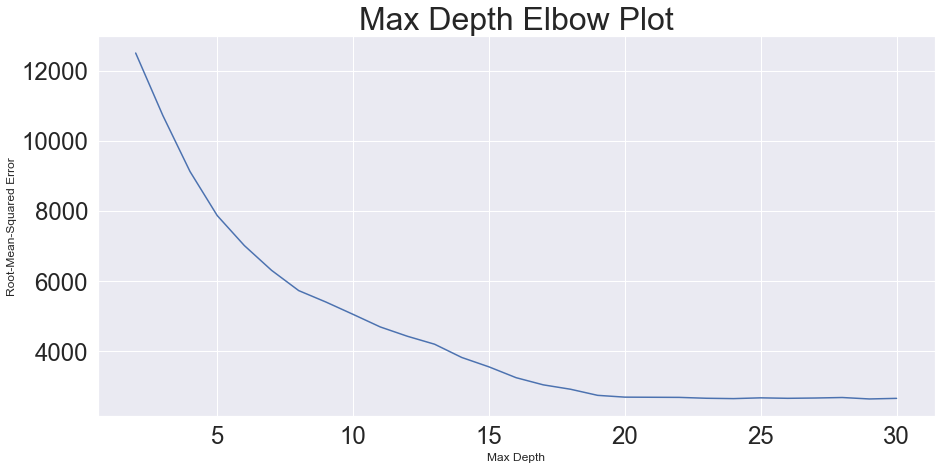

In [178]:
fig = plt.figure(figsize=(15,7))
_ = sns.lineplot(x='Max Depth', y='Root-Mean-Squared Error', data=RFElbow)
_ = plt.title('Max Depth Elbow Plot')

It looks like 19 is a good max depth for Random Forest Regression

In [182]:
# Let's try max_depth = 19
reg = RandomForestRegressor(max_depth=19, random_state=42)
reg.fit(X_train0, np.ravel(y_train0))
y_pred0 = reg.predict(X_test0)
print('Regression training score = ' + str(round(reg.score(X_train0, y_train0), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test0, y_pred0), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test0, y_pred0, squared=False))))

Regression training score = 0.9868
R2 testing score = 0.9719
Root-mean-squared test score 2747.0


In [174]:
S2mask = X_test.Store_5 == 1
D2mask = X_test.Dept_5 == 1

In [175]:
S2D2X_test = X_test.loc[S2mask].loc[D2mask]
S2D2X_testIDX = S2D2X_test.index

In [176]:
S2D2y_test = y_test.loc[S2D2X_testIDX]

In [177]:
S2D2y_pred = reg.predict(S2D2X_test)

In [178]:
round(mean_squared_error(S2D2y_test, S2D2y_pred), 2)

16650300.99

In [179]:
round(r2_score(S2D2y_test, S2D2y_pred), 2)

-6.86

*I'm not happy with how this performs on specific stores and departments. I should create different models fit by store Type.*

Let's try KNN and see how it does

In [59]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
knn = KNeighborsRegressor()

In [60]:

param_grid = {'n_neighbors':[5, 10, 15, 20, 25, 30]}
gcv = GridSearchCV(knn, param_grid)

In [61]:
gcv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30]})

*I should split the train and test data at a certain point in time rather than doing it randomly. This will simulate the type of predictive modeling this would be intended for in practice.*

In [62]:
gcv.best_estimator_

KNeighborsRegressor()

In [63]:
gcv.best_params_

{'n_neighbors': 5}

In [64]:
gcv.best_score_

0.13303730697379573

In [65]:
y_pred = gcv.predict(X_test)

In [66]:
round(reg.score(X_train, y_train), 2)

0.87

In [67]:
round(mean_squared_error(y_test, y_pred), 2)

426605450.79

In [68]:
round(r2_score(y_test, y_pred), 2)

0.18

KNN performed horribly. Definitely overfit the data. Could be due to the curse of dimensionality. Could function better on data that's had its dimensionality reduced by PCA.

Once I find a good model that works I should filter the test data by a particular store/department, run it through and then compare the y_pred vs y_test